# Testing regridding using sparse matrix multiplication

These tests use a compact regridder implementing sparse matrix multiplication from the external module [smmregrid](https://github.com/jhardenberg/smmregrid). The library has no other significant dependencies (it does not use iris or esmf for regridding) but it can use cdo to generate weights.
The essence is basically sparse matrix multiplication using dask + some manipulation of the coordinates (which would have to be revised/checked again).

Works with data on levante.

Totally optional. We initiate a cluster client with 16 workers.

In [1]:
from dask.distributed import LocalCluster, Client, progress
cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
client = Client(cluster)
#client = Client(ip="0.0.0.0", processes=True, threads_per_worker=8,
#               n_workers=4, memory_limit='8GB'
cluster

2023-01-29 12:58:31,996 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-ju09j0y5', purging
2023-01-29 12:58:31,996 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-kdobdfjz', purging
2023-01-29 12:58:31,997 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-kxrdd7j_', purging
2023-01-29 12:58:31,997 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-_5xw4bit', purging
2023-01-29 12:58:31,997 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-ofqyuv4a', purging
2023-01-29 12:58:31,997 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-5gpgkl0x', purging
2023-01-29 12:58:31,997 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/d

LocalCluster(dc611e5c, 'tcp://136.172.124.7:42417', workers=16, threads=32, memory=503.45 GiB)

In [3]:
# Temporary hack
#import sys
#sys.path.append("../..")

## Test 1: EC-Earth3 daily (165 years) to 2x2 resolution using climtas

We test climtas regridding using daily EC-Earth3 data from ESGF

In [2]:
import xarray as xr

# This is a standard ESGF folder containing daily tas from EC-Earth (point it to your own)
src =  "/work/bb1153/b382075/datasets/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/day/tas/gr/v20200310/tas*.nc"
src_ds = xr.open_mfdataset(src)

# We use this sample file to describe the target grid which we intend, 2x2 deg in this case
dest = 'data/r180x91/climate_CRU_t2m.nc'
dest_ds = xr.open_dataset(dest)


We precomputed weights for these target to destination resolutions using cdo genycon (area conserving conservative remapping using the YAC algorithm)

In [7]:
# cdo genycon,data/r180x91/climate_CRU_t2m.nc /work/bb1153/b382075/datasets/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/day/tas/gr/v20200310/tas_day_EC-Earth3_historical_r1i1p1f1_gr_19660101-19661231.nc weights_ecearth_ycon.nc

Now we import the smmregrid library (this is a subset of the original at https://github.com/ScottWales/climtas)

In [2]:
from smmregrid import Regridder

Use precomputed weights

In [4]:

weights = xr.open_mfdataset("/work/bb1153/b382075/sample/weights/weights_ecearth_ycon.nc")
weights


<xarray.Dataset>
Dimensions:              (src_grid_rank: 2, dst_grid_rank: 2,
                          src_grid_size: 131072, dst_grid_size: 16380,
                          num_links: 239432, num_wgts: 1)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, src_grid_size,
                                dst_grid_size, num_links, num_wgts
Data variables: (12/15)
    src_grid_dims        (src_grid_rank) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    dst_grid_dims        (dst_grid_rank) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    src_grid_center_lat  (src_grid_size) float64 dask.array<chunksize=(131072,), meta=np.ndarray>
    dst_grid_center_lat  (dst_grid_size) float64 dask.array<chunksize=(16380,), meta=np.ndarray>
    src_grid_center_lon  (src_grid_size) float64 dask.array<chunksize=(131072,), meta=np.ndarray>
    dst_grid_center_lon  (dst_grid_size) float64 dask.array<chunksize=(16380,), meta=np.ndarray>
    ...                   ...
    dst_grid_area        (dst_grid_size) float64 dask.array<chunksize=(16380,), meta=np.ndarray>
    src_grid_frac        (src_grid_size) float64 dask.array<chunksize=(131072,), meta=np.ndarray>
    dst_grid_frac        (dst_grid_size) float64 dask.array<chunksize=(16380,), meta=np.ndarray>
    src_address          (num_links) int32 dask.array<chunksize=(239432,), meta=np.ndarray>
    dst_address          (num_links) int32 dask.array<chunksize=(239432,), meta=np.ndarray>
    remap_matrix         (num_links, num_wgts) float64 dask.array<chunksize=(239432, 1), meta=np.ndarray>
Attributes:
    title:          SCRIP remapping with CDO
    normalization:  fracarea
    map_method:     Conservative remapping using clipping on sphere
    conventions:    SCRIP
    source_grid:    gaussian
    dest_grid:      lonlat
    history:        08 Sep 2022 : cdo genycon,/home/pdavini/ECmean4/climatolo...
    CDO:            Climate Data Operators version 1.9.9rc1 (https://mpimet.m...

Instantiate a regridder object with the weights which we have just loaded and then apply it to regrid tas from the sample source dataset

In [5]:
regridder = Regridder(weights=weights)

In [6]:
tasr = regridder.regrid(src_ds.tas)

/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3382: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  if await self.run_code(code, result, async_=asy):


Let's give a look at the resulting tasr array. It is still dask chunked.

In [17]:
tasr

<xarray.DataArray 'tas' (time: 60265, lat: 91, lon: 180)>
dask.array<reshape, shape=(60265, 91, 180), dtype=float64, chunksize=(366, 91, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
    height   float64 2.0
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

Compute something useful (and finally do the calculation)

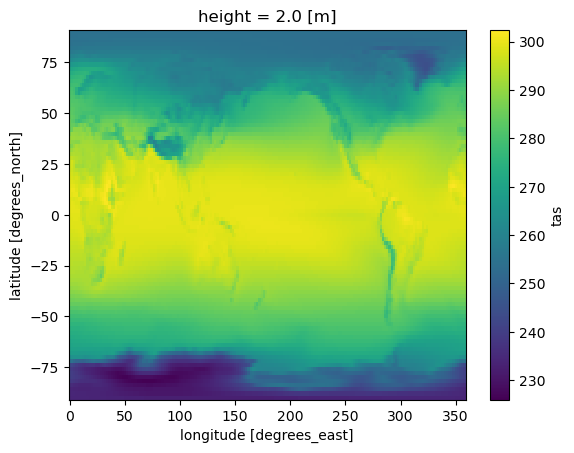

In [7]:
tasr.mean(dim='time').plot()

This takes about 18s on levante with 16 workers, sweet.

## Interlude: the same with xesmf

Little hack to make it work ... another reason not to use xesmf

(Notice, this part is not working for me at the moment due to some environment issue)

In [3]:
os.environ["ESMFMKFILE"] = "/home/b/b382075/mambaforge/envs/aqua/lib/esmf.mk"

Here we test it with xesmf, but using bilinear interpolation (it throws an error if I try and use conservative)

In [4]:
import xesmf as xe
interp = xe.Regridder(src_ds, dest_ds, periodic = False, method = "bilinear")

In [5]:
interp(src_ds['tas']).mean(dim="time").plot(vmin=225, vmax=300)

2023-01-29 12:59:07,599 - distributed.worker - ERROR - Could not deserialize task ('mean_chunk-2026a49e0166b5cb6a96190174f703a0', 75, 0, 0)
Traceback (most recent call last):
  File "/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/esmpy/interface/loadESMF.py", line 26, in <module>
    esmfmk = os.environ["ESMFMKFILE"]
  File "/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/os.py", line 679, in __getitem__
    raise KeyError(key) from None
KeyError: 'ESMFMKFILE'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/xesmf/backend.py", line 22, in <module>
    import esmpy as ESMF
  File "/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/esmpy/__init__.py", line 112, in <module>
    from esmpy.api.esmpymanager import *
  File "/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/esmpy/api/esmpymanager.py", line 9, in <mo

ModuleNotFoundError: No module named 'ESMF'

About the same time (16s on levante).

## Test 2: More serious stuff, ICON 5km data (original grid) again to 2x2deg grid

This is something which (apparently) at the moment we cannot do with xesmf since the source data are on an unstructured grid.

In [7]:
import xarray as xr

# This is sample data from the ngc2009 ICON experiment
src =  "/work/bm1235/k203123/experiments/ngc2009/run_20210911T000000-20210925T235920/ngc2009_atm_2d_30min_inst_20210921T000000Z.nc"
src_ds = xr.open_mfdataset(src)

# We use this sample file to describe the target grid which we intend, 2x2 deg in this case
dest = 'data/r180x91/climate_CRU_t2m.nc'
dest_ds = xr.open_dataset(dest)


Precomputed weights using CDO

In [ ]:
# cdo genycon,data/r180x91/climate_CRU_t2m.nc ../../destine/nextgems/ngc2009_atm_2d_30min_inst_20220225T000000Z.tas.nc weights_icon_ycon.nc

In [8]:
weights = xr.open_mfdataset("/work/bb1153/b382075/sample/weights/weights_icon_ycon.nc")

and now we use smmregrid regridding using the precomputed weights. Notice that the package also proivides functions to call cdo or ESMF and compute the weights from inside python. It recognizes automatically (from the filename) if weights are CDO or ESMF style.

In [9]:
from smmregrid import Regridder

In [10]:
regridder = Regridder(weights=weights)

In [11]:
tasr = regridder.regrid(src_ds.tas)

In [12]:
tasr

<xarray.DataArray 'tas' (time: 48, height: 1, lat: 91, lon: 180)>
dask.array<reshape, shape=(48, 1, 91, 180), dtype=float64, chunksize=(48, 1, 91, 180), chunktype=numpy.ndarray>
Coordinates:
  * height   (height) float64 2.0
  * time     (time) datetime64[ns] 2021-09-21 ... 2021-09-21T23:30:00
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

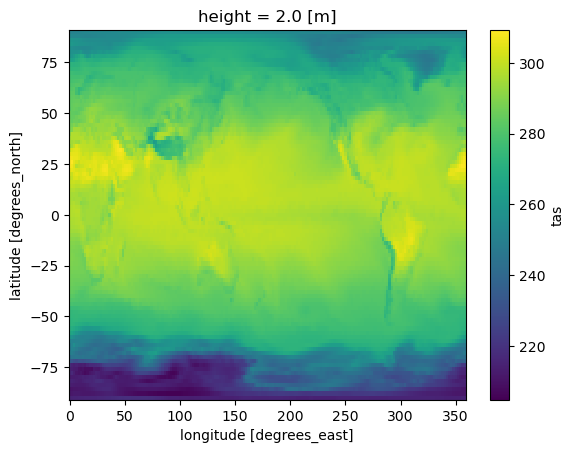

In [13]:
tasr.mean(dim="time").plot()

20s on levante! This is really cool. 

## Test 3: FESOM example

In [14]:
import xarray as xr

# This is sample data downloaded from https://swift.dkrz.de/v1/dkrz_0262ea1f00e34439850f3f1d71817205/FESOM/tos_Omon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-185012.nc
src =  "/work/bb1153/b382075/sample/data/tos_Omon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-185012.nc"
src_ds = xr.open_mfdataset(src)

# We use this sample file to describe the target grid which we intend, 2x2 deg in this case
dest = 'data/r180x91/climate_CRU_t2m.nc'
dest_ds = xr.open_mfdataset(dest)


Precompute weights

In [8]:
# cdo genycon,/work/users/jost/aqua/AQUA/playground/regrid/data/r180x91/climate_CRU_t2m.nc  tos_Omon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-185012.nc weights_fesom.nc

In [16]:

weights = xr.open_dataset("/work/bb1153/b382075/sample/weights/weights_fesom_ycon.nc")
regridder = Regridder(weights=weights)
tosr = regridder.regrid(src_ds.tos)

In [18]:
tosr

<xarray.DataArray 'tos' (time: 12, lat: 91, lon: 180)>
dask.array<reshape, shape=(12, 91, 180), dtype=float64, chunksize=(12, 91, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

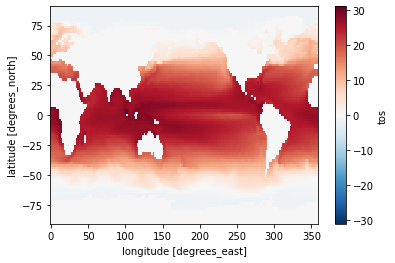

In [19]:
tosr.mean(dim='time').plot()

# Test 4: IFS 4km Tco2559

Data downloaded from levante `/work/bm1235/a270046/cycle2-sync/tco2559-ng5/12_01Dec-31Dec2020_fesom`

In [19]:
import xarray as xr
import cfgrib 

# IFS 4km tco2559
# The filter_by_keys is needed because variable lnsp is grib edition 2 and all others are 1
src = "/work/bm1235/a270046/cycle2-sync/tco2559-ng5/12_01Dec-31Dec2020_fesom/ICMUAhqys+162240"
src_ds = xr.open_mfdataset(src, engine='cfgrib', 
                           backend_kwargs={'filter_by_keys': {'edition': 1}})

# We use this sample file to describe the target grid which we intend, 2x2 deg in this case
dest = 'data/r180x91/climate_CRU_t2m.nc'
dest_ds = xr.open_mfdataset(dest)


Can't create file '/work/bm1235/a270046/cycle2-sync/tco2559-ng5/12_01Dec-31Dec2020_fesom/ICMUAhqys+162240.923a8.idx'
Traceback (most recent call last):
  File "/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/cfgrib/messages.py", line 534, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/contextlib.py", line 119, in __enter__
    return next(self.gen)
  File "/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/cfgrib/messages.py", line 500, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: '/work/bm1235/a270046/cycle2-sync/tco2559-ng5/12_01Dec-31Dec2020_fesom/ICMUAhqys+162240.923a8.idx'
Can't read index file '/work/bm1235/a270046/cycle2-sync/tco2559-ng5/12_01Dec-31Dec2020_fesom/ICMUAhqys+162240.923a8.idx'
Traceback (most recent call last):
  File "/home/b/b382075/mambafo

The weights were computed using

In [23]:
# cdo genycon,/work/users/jost/aqua/AQUA/playground/regrid/data/r180x91/climate_CRU_t2m.nc /work/users/jost/destine/ifs/4km/tco2559_grid.nc weights_ifs4km.nc

In [20]:
weights = xr.open_dataset("/work/bb1153/b382075/sample/weights/weights_ifs4km_ycon.nc")

But this time let's show also how to compute them using smmregrid itself (it calls cdo - this takes about 2 min):

In [22]:
from smmregrid import cdo_generate_weights, Regridder
src = "/work/bm1235/a270046/cycle2-sync/tcogrids/4km/tcogrids/tco2559_grid.nc"
src_grid = xr.open_mfdataset(src)
weights = cdo_generate_weights(src_grid, dest_ds, method='ycon', extrapolate=True, remap_norm='fracarea', remap_area_min=0.0)

In [23]:
regridder = Regridder(weights=weights)
zr = regridder.regrid(src_ds.z)

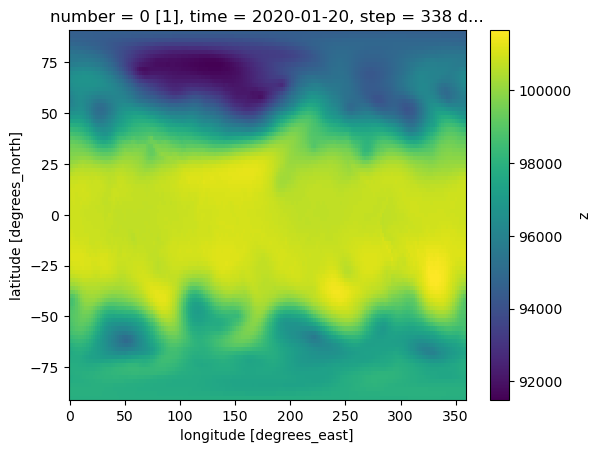

In [24]:
zr.mean(dim='isobaricInhPa').plot()

## Test 5: NEMO ORCA1 (EC-Earth3, CMIP6)

In [25]:
import xarray as xr
import smmregrid

# These are CMIP6 EC-Earth3 data
src = "/work/bb1153/b382075/datasets/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Omon/tos/gn/v20200918/tos*.nc"
src_ds = xr.open_mfdataset(src)

# We use this sample file to describe the target grid which we intend, 2x2 deg in this case
dest = 'data/r180x91/climate_CRU_t2m.nc'
dest_ds = xr.open_mfdataset(dest)


remapycon and remapcon currently fail (already with command-line CDO). Using bilinear for now

In [26]:
weights = smmregrid.cdo_generate_weights(src_ds.tos[0,:,:], dest_ds, method='bil', 
            extrapolate=True, remap_norm='fracarea', remap_area_min=0.0)

In [27]:
# For next time
weights.to_netcdf("/work/bb1153/b382075/sample/weights/weights_nemo_orca1.nc")

In [28]:
regridder = Regridder(weights=weights)
sstr = regridder.regrid(src_ds.tos)

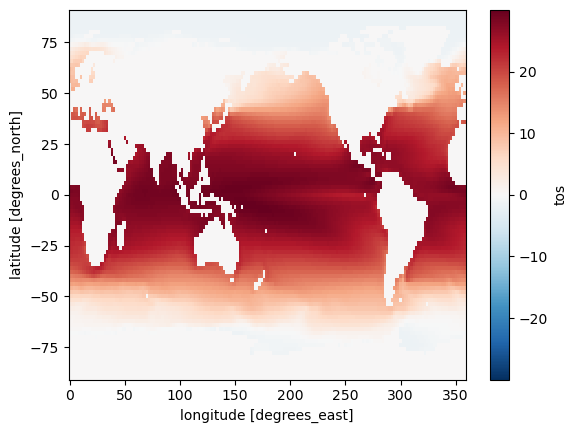

In [29]:
sstr.mean(dim='time').plot()